#                   TP Go - IA - S8 - I2G1 - ddelpy - allaguierce



In [4]:
# Some imports and constants.

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import gzip, os.path, json, urllib.request

NB_COLUMNS = NB_LINES = 8


To import the data.

Data Form:
``list[dict]`` where `dict` follows:
```yml
dict_keys([
  'depth',
  'list_of_moves',
  'black_stones',
  'white_stones',
  'rollouts',
  'black_wins',
  'black_points',
  'white_wins',
  'white_points'])
```


In [5]:
# Retrieve *example data*.
def get_raw_data_go() -> list:
    ''' Returns the set of samples from the local file
    or download it if it does not exists
    '''
    raw_samples_file: str = "samples-8x8.json.gz"

    if not os.path.isfile(raw_samples_file):
        print("File",
              raw_samples_file,
              "not found, I am downloading it...",
              end="")

        urllib.request.urlretrieve(
    "https://www.labri.fr/perso/lsimon/static/inge2-ia/samples-8x8.json.gz",
            "samples-8x8.json.gz")
        print(" Done")

    with gzip.open("samples-8x8.json.gz") as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

# get evalutation data
def get_eval_set_go() -> list:
    ''' Returns the set of samples from the local file
    or download it if it does not exists
    '''
    raw_samples_file: str = "positions-to-evaluate-8x8-2025.json.gz"

    if not os.path.isfile(raw_samples_file):
        print("File",
              raw_samples_file,
              "not found, I am downloading it...",
              end="")

        urllib.request.urlretrieve(
    "https://www.labri.fr/perso/lsimon/static/inge2-ia/positions-to-evaluate-8x8-2025.json.gz",
            "positions-to-evaluate-8x8-2025.json.gz")
        print(" Done")

    with gzip.open("positions-to-evaluate-8x8-2025.json.gz") as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data



In [6]:
# Switching device
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print(f'The device used is: {device}')


The device used is: cuda


To Transform the data.

In [7]:

def name_to_coord(s: str) -> (int, int):
    """
    You can't give "PASS" to it.
    """
    indexLetters: dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3,
                          'E': 4, 'F': 5, 'G': 6, 'H': 7}

    column: int = indexLetters[s[0]] # Between 0 and 7
    line: int = int(s[1:]) - 1       # Between 0 and 7
    return (column, line)

def arrayed(stones: list) -> np.ndarray:
    """ A function to apply `name_to_coord` on numpy arrays.
    :return: a numpy array such as shape=(len(stones), 2).
    """
    return np.array(list(map(name_to_coord, stones)))

def split_channels(matrix: np.ndarray) -> np.ndarray:
    """ Pytorch wants this.
    """
    black: np.ndarray = (matrix == 1).astype(np.float32)
    white: np.ndarray = (matrix == 2).astype(np.float32)
    return np.stack([black, white], axis=0)

def transform_position(black_stones: list, white_stones: list) -> np.ndarray[int]:
    """
    :return: a numpy array of size (NB_LINES, NB_COLUMNS) such as:
    array[i][j] == 1 if 'str(j)i' belongs to *black*,
    array[i][j] == 2 if 'str(j)i' belongs to *whites*,
    array[i][j] == 0 otherwise.
    """
    # Format input.
    if "PASS" in black_stones:
        black_stones.remove("PASS")
    if "PASS" in white_stones:
        white_stones.remove("PASS")

    matrix = np.zeros(shape=(NB_LINES, NB_COLUMNS), dtype=int)

    # Black stones
    if black_stones != []:
        black_coords: np.ndarray = arrayed(black_stones)
        # line is black_coords[:, 1], column is black_coords[:, 0].
        matrix[black_coords[:, 1], black_coords[:, 0]] = 1

    # White stones
    if white_stones != []:
        white_coords: np.ndarray = arrayed(white_stones)
        matrix[white_coords[:, 1], white_coords[:, 0]] = 2

    # Torch is waiting for something with the shape=[batch_size, 2, 8, 8].
    return split_channels(matrix)

def transform_data(data: list[dict]) -> np.ndarray[np.ndarray]:
    """
    :param data: the list of games according to the *raw data*.
            A game could be:
```
{'depth': 1,
'list_of_moves': ['E5', 'C5'], 'black_stones': ['E5'], 'white_stones': ['C5'],
'rollouts': 100,
'black_wins': 94, 'black_points': 1236.0,
'white_wins': 4, 'white_points': 60.0}
```
    :return: all the games, in a *numpy.array* form, the initial order is kept.
    """
    lst: list = []

    for pos in data:
        lst.append(
            transform_position(pos["black_stones"], pos["white_stones"])
        )

    return np.stack(lst, axis=0)


Creating the model.

In [8]:
class GoNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.conv1(x)) # [batch, 32, 8, 8]
        x = torch.relu(self.conv2(x)) # [batch, 64, 8, 8]
        x = x.view(x.size(0), -1) # flatten
        x = torch.relu(self.fc1(x)) # [batch, 128]
        x = self.sigmoid(self.fc2(x)) # [batch, 1]
        return x

Initialization, of the model.

In [9]:
model = GoNet()

# Want big gpu.
model = model.to(device)

data = get_raw_data_go()
batch_size = 32
epochs = 20
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

File samples-8x8.json.gz not found, I am downloading it... Done


Data conversion, to be given to the model.

In [10]:
N = 2 * int(len(data) / 3) # The training set is `data[:N]`.
training_set: list = data[:N]

# Construct the training dataset.
Xtrain_np = transform_data(training_set)
Ytrain_np = np.array(
            [d['black_wins'] / d['rollouts'] for d in training_set],
            dtype=np.float32
        ).reshape(-1, 1)

Xtrain: torch.tensor = torch.from_numpy(Xtrain_np).float()
Ytrain: torch.tensor = torch.from_numpy(Ytrain_np).float()
dataset_train = TensorDataset(Xtrain, Ytrain)

# Here is the test "dataset".
testing_set: list = data[N:]

To train the model.

In [11]:
def train(model, device, trainloader,  optimizer, epoch, loss_f):
    model.train()
    total_loss = 0

    for data, target in trainloader:
        optimizer.zero_grad()

        # Want big gpu.
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = loss_f(output, target)
        total_loss += loss.item() * len(data) # We average the loss
        loss.backward()
        optimizer.step()

    total_loss /= len(trainloader.dataset)

    return {"loss": total_loss}

Training time

In [12]:
train_losses = []

trainloader = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size,
                                          shuffle=True)

for epoch in range(1, epochs):
    train_stats = train(model, device, trainloader, optimizer, epoch, criterion)
    train_losses.append(train_stats['loss'])
    print(train_stats)


{'loss': 0.5313530040061841}
{'loss': 0.444904624017238}
{'loss': 0.4261975094399532}
{'loss': 0.41412312694339837}
{'loss': 0.40575792851469406}
{'loss': 0.3933170222326372}
{'loss': 0.38503185472293205}
{'loss': 0.37762832863865653}
{'loss': 0.36726081076533124}
{'loss': 0.36298803760380394}
{'loss': 0.35640748994900046}
{'loss': 0.35121533191812554}
{'loss': 0.34731833639235093}
{'loss': 0.3440834258181224}
{'loss': 0.3418515400265659}
{'loss': 0.3406734767243988}
{'loss': 0.3374759536036153}
{'loss': 0.3364493636678388}
{'loss': 0.33445575645159975}


To do predictions.

In [13]:
def position_predict(black_stones: list, white_stones: list) -> float:
    Xpos_np: np.ndarray = transform_position(black_stones, white_stones)
    Xpos: torch.tensor = torch.from_numpy(Xpos_np).float()

    # Add a layer of `[]` to the tensor.
    Xpos = Xpos.unsqueeze(0)

    # Want big gpu.
    Xpos = Xpos.to(device)

    prediction = model(Xpos)
    return float(prediction[0][0])

Generate the output file.

In [14]:
evaluation_set: list = get_eval_set_go()

def create_result_file(newdata: list) -> None:
    """
    :param newdata: should be a part of `data`.
    """
    if newdata == []:
        return

    resultat  = [
        position_predict(d["black_stones"], d["white_stones"])
        for d in newdata
    ]

    with open("./my_predictions.txt", "w") as f:
         for p in resultat:
            f.write(str(p)+"\n")

# Save the results for the testing set.
create_result_file(evaluation_set)


File positions-to-evaluate-8x8-2025.json.gz not found, I am downloading it... Done


To save the current model.

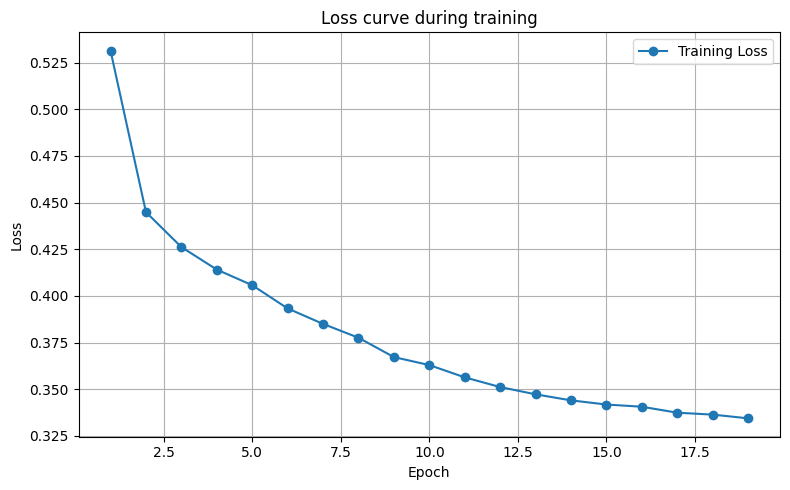

In [15]:
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs), train_losses, marker='o', label='Training Loss')
plt.title("Loss curve during training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Save model

In [16]:

torch.save(model, './model.pt')

# EOF